In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import pickle
import numpy as np
import pandas as pd
from IPython.display import clear_output
from scipy.stats import norm

In [16]:
problem_type = 'oil'
problem = 'quadratic'
param = '1'
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rcParams.update({'font.size': 8})

In [17]:
grid_size = .01
H = 5

In [18]:
grid = np.arange(0, 1+grid_size, grid_size)

In [19]:
Q_vals = np.zeros([H, len(grid), len(grid)])
r_vals = np.zeros([H, len(grid), len(grid)])
V_vals = np.zeros([H, len(grid)])

In [20]:
# ## QUADRATIC

def f(h,state,action):
    return 1 - 1*(state - .75)**2
def sigma(h, state, action):
    return 0

# ## LAPLACE
# def f(h, state, action):
#     return 1 - np.exp(-10*np.abs(state - .7))
# def sigma(h, state, action):
#     return 0
# # ## NOISE
# # def f(h, state, action):
# #     return 1 - np.exp(-10*np.abs(state*action - .7))
# # def sigma(h, state, action):
# #     return .1*(state + action)**2
# # SPARSE 
# def f(h, state, action):
#     if h == 0:
#         return (1/5)*(h+1)*np.exp(-1*np.abs(state - .5))
#     elif h == 1:
#         return (1/5)*(h+1)*np.exp(-1*np.abs(state - .25))  
#     elif h == 2:
#         return (1/5)*(h+1)*np.exp(-1*np.abs(state - .5))     
#     elif h == 3:
#         return (1/5)*(h+1)*np.exp(-1*np.abs(state - .75))     
#     elif h == 4:
#         return (1/5)*(h+1)*np.exp(-1*np.abs(state - 1))    
# def sigma(h, state, action):
#     return .025*(state+action)**2

alpha = 1

In [21]:
for h in np.arange(H-1, -1, -1):
    print(h)
    for s in range(len(grid)):
        for a in range(len(grid)):
            state = grid[s]
            action = grid[a]
            r_vals[h,s,a]= min(max(f(h,state,action) - alpha*np.abs(state-action),0),1)
            if h == H-1:
                Q_vals[h,s,a] = min(max(f(h,state,action) - alpha*np.abs(state-action),0),1)
            else:
                variance = sigma(h, state, action)
                if variance == 0:
                    Q_vals[h,s,a] = min(max(f(h,state,action) - alpha*np.abs(state-action),0),1) + V_vals[h+1, a]
                else:
                    lhs = np.copy(grid)
                    lhs[0] = float('-inf')
                    
                    rhs = np.copy(grid)+grid_size
                    rhs[-1] = float('inf')
                    weights = norm.cdf(rhs, action, np.sqrt(variance)) \
                                        - norm.cdf(lhs, action, np.sqrt(variance))

                    v_Est = np.dot(weights, V_vals[h+1, :])
                    Q_vals[h,s,a] = min(max(f(h,state,action) - alpha*np.abs(state-action),0),1) + v_Est
                    
        V_vals[h,s] = np.max(Q_vals[h,s,:])

4
3
2
1
0


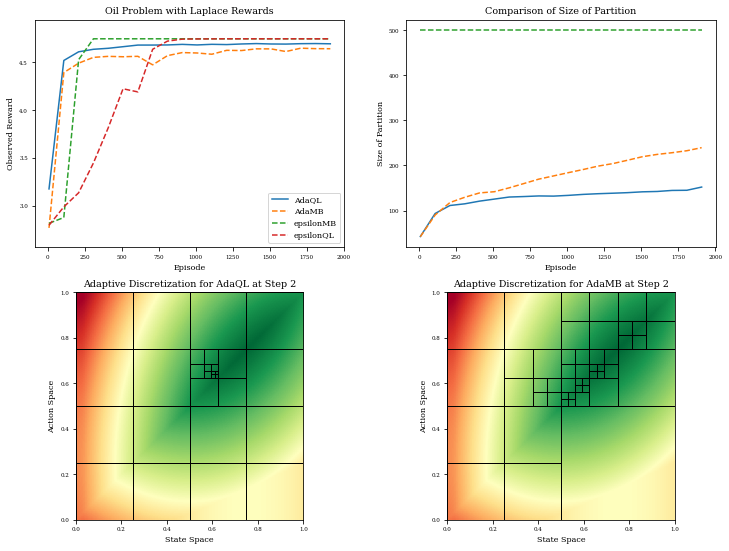

In [31]:
problem = 'oil'
typ = 'quadratic'
param = '1'


        
        
        
name_adapt = './data/'+problem+'_'+typ+'_'+param+'_adaQL.csv'
name_adapt_model_based = './data/'+problem+'_'+typ+'_'+param+'_adaMB_Full.csv'
# name_adapt_flag_model_based = './data/oil_'+problem+'_'+'adapt_flag_'+param+'.csv'
name_net = './data/'+problem+'_'+typ+'_'+param+'_epsQL.csv'
name_enet_model = './data/'+problem+'_'+typ+'_'+param+'_epsMB_One.csv'

dt_adapt_model = pd.read_csv(name_adapt_model_based).groupby(['episode']).mean()
dt_net_model = pd.read_csv(name_enet_model).groupby(['episode']).mean()
dt_adapt = pd.read_csv(name_adapt).groupby(['episode']).mean()
dt_net = pd.read_csv(name_net).groupby(['episode']).mean()

max_val = max(dt_adapt.tail(1)['epReward'].iloc[0], dt_adapt_model.tail(1)['epReward'].iloc[0], dt_net.tail(1)['epReward'].iloc[0], dt_net_model.tail(1)['epReward'].iloc[0])
min_val = min(dt_adapt.head(1)['epReward'].iloc[0], dt_adapt_model.head(1)['epReward'].iloc[0], dt_net.head(1)['epReward'].iloc[0], dt_net_model.head(1)['epReward'].iloc[0])

dt_adapt_model['episode'] = dt_adapt_model.index.values
dt_adapt_model = dt_adapt_model.iloc[::10, :]
dt_net_model['episode'] = dt_net_model.index.values
dt_net_model = dt_net_model.iloc[::10, :]
dt_adapt['episode'] = dt_adapt.index.values
dt_net['episode'] = dt_net.index.values
dt_net = dt_net.iloc[::10, :]
dt_adapt = dt_adapt.iloc[::10, :]


fig = plt.figure(figsize=(12.2, 9.2))
plt.subplot(2,2,1)

plt.plot(dt_adapt['episode'], dt_adapt['epReward'], label='AdaQL')
plt.plot(dt_adapt_model['episode'], dt_adapt_model['epReward'], label='AdaMB', linestyle='--')
# plt.plot(dt_adapt_model_flag['episode'], dt_adapt_model_flag['epReward'], label='ModelAdaptiveFlag', linestyle='--')
plt.plot(dt_net_model['episode'], dt_net_model['epReward'], label='epsilonMB', linestyle='--')
plt.plot(dt_net['episode'], dt_net['epReward'], label = 'epsilonQL', linestyle='--')

plt.ylim(min_val - .2,max_val+.2)
plt.xlabel('Episode')
plt.ylabel('Observed Reward')
plt.legend()
plt.title('Oil Problem with Laplace Rewards')



plt.subplot(2,2,2)
plt.plot(dt_adapt['episode'], dt_adapt['Number of Balls'], label='AdaQL')
plt.plot(dt_adapt_model['episode'], dt_adapt_model['Number of Balls'], label='AdaMB', linestyle='--')
plt.plot(dt_net['episode'], dt_net['Number of Balls'], linestyle = '--', label='epsilon')
# plt.legend()

plt.xlabel('Episode')
plt.ylabel('Size of Partition')
plt.title('Comparison of Size of Partition')

plt.subplot(2,2,3)
h = 2
name_obj = './data/'+problem+'_'+typ+'_'+param+'_adaQL.obj'
infile = open(name_obj,'rb')
agent = pickle.load(infile)
infile.close()
tree = agent.tree_list[h-1]
tree.plot(fig)
im = plt.imshow(Q_vals[h,:,:], cmap='RdYlGn', extent = (0,1,0,1), origin='lower')

plt.title('Adaptive Discretization for AdaQL at Step 2')

plt.subplot(2,2,4)
name_obj = './data/'+problem+'_'+typ+'_'+param+'_adaMB_Full.obj'
infile = open(name_obj,'rb')
agent = pickle.load(infile)
infile.close()
tree = agent.tree_list[h-1]
tree.plot(fig)
im = plt.imshow(Q_vals[h,:,:], cmap='RdYlGn', extent = (0,1,0,1), origin='lower')
plt.title('Adaptive Discretization for AdaMB at Step 2')



plt.show()
fig.savefig('adaptive_discretization_presentation.png', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)

